In [5]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.8 MB/s eta 0:00:00


In [6]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
!gdown '1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q'

Downloading...
From: https://drive.google.com/uc?id=1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q
To: /content/dataset.zip
100% 230k/230k [00:00<00:00, 65.3MB/s]


In [8]:
!unzip '/content/dataset.zip' -d '/content/'

Archive:  /content/dataset.zip
   creating: /content/dataset/
  inflating: /content/dataset/all-data.csv  


In [11]:
data_path = 'dataset/all-data.csv'
headers = ['sentiment', 'content']
df = pd.read_csv(
    data_path,
    names=headers,
    encoding='ISO-8859-1'
)
df

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [12]:
classes = {
    class_name: idx for idx, class_name in enumerate(df['sentiment'].unique().tolist())
}
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])

In [13]:
df

,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...
...,...,...
4841,1,LONDON MarketWatch -- Share prices ended lower...
4842,0,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,1,Operating profit fell to EUR 35.4 mn from EUR ...
4844,1,Net sales of the Paper segment decreased to EU...


In [48]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
  text = text.lower()
  text = text.strip()
  text = re.sub(r'[^\w\s]', '', text)
  text = unidecode.unidecode(text)
  text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
  text = ' '.join([stemmer.stem(word) for word in text.split(' ')])

  return text

In [49]:
df['content'] = df['content'].apply(lambda x: text_normalize(x))

In [50]:
df

,sentiment,content
0,0,accord gran compani plan move product russia ...
1,0,technopoli plan develop stage area less 100000...
2,1,intern electron industri compani elcoteq laid ...
3,2,new product plant compani would increa capac m...
4,2,accord compani updat strategi year 20092012 b...
...,...,...
4841,1,london marketwatch share price end lower lond...
4842,0,rinkuskiai beer sale fell 65 per cent 416 mill...
4843,1,oper profit fell eur 354 mn eur 688 mn 2007 i...
4844,1,net sale paper segment decrea eur 2216 mn seco...


In [51]:
vocab = []
for sentence in df['content'].tolist():
  for word in sentence.split(' '):
    if word not in vocab:
      vocab.append(word)

vocab.append('UNK')
vocab.append('PAD')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

In [56]:
def transform(text, word_to_idx, max_seq_length):
  tokens = []
  for word in text.split(' '):
    try:
      word_ids = word_to_idx[word]
    except:
      word_ids = word_to_idx['UNK']
    tokens.append(word_ids)

  if len(tokens) < max_seq_length:
    tokens += [word_to_idx['PAD']] * (max_seq_length - len(tokens))
  elif len(tokens) > max_seq_length:
    tokens = tokens[:max_seq_length]

  return tokens

In [57]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

In [58]:
class FinancialNews(Dataset):
  def __init__(
      self,
      X, y,
      word_to_idx,
      max_seq_length,
      transform=None
  ):
    self.texts = X
    self.labels = y
    self.word_to_idx = word_to_idx
    self.max_seq_length = max_seq_length
    self.transform = transform

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]

    if self.transform:
      text = self.transform(
          text,
          self.word_to_idx,
          self.max_seq_length
      )

    text = torch.tensor(text)

    return text, label

In [59]:
max_seq_length = 32

train_dataset = FinancialNews(
    X_train, y_train,
    word_to_idx=word_to_idx,
    max_seq_length=max_seq_length,
    transform=transform
)
val_dataset = FinancialNews(
    X_val, y_val,
    word_to_idx=word_to_idx,
    max_seq_length=max_seq_length,
    transform=transform
)
test_dataset = FinancialNews(
    X_test, y_test,
    word_to_idx=word_to_idx,
    max_seq_length=max_seq_length,
    transform=transform
)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [60]:
class SentimentClassifier(nn.Module):
  def __init__(
      self,
      vocab_size,
      embedding_dim,
      hidden_size,
      n_layers,
      n_classes,
      dropout_prob
  ):
    super(SentimentClassifier, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
    self.norm = nn.LayerNorm(hidden_size)
    self.dropout = nn.Dropout(dropout_prob)
    self.fc1 = nn.Linear(hidden_size, 16)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(16, n_classes)

  def forward(self, x):
    x = self.embedding(x)
    x, hn = self.rnn(x)
    x = x[:, -1, :]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x

In [61]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
drop_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=drop_prob
).to(device)

In [62]:
lr = 1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

In [63]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  total = 0
  correct = 0
  losses = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  loss = sum(losses) / len(losses)
  acc = correct / total

  return loss, acc

In [64]:
def fit(model, train_loader, val_loader, criterion, optimizer, epochs, device):
  train_losses = []
  val_losses = []
  for epoch in range(epochs):
    batch_losses = []
    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      batch_losses.append(loss.item())
      loss.backward()
      optimizer.step()

    train_loss = sum(batch_losses) / len(batch_losses)
    train_losses.append(train_loss)

    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

  return train_losses, val_losses

In [65]:
train_losses, val_losses = fit(
    model,
    train_loader, val_loader,
    criterion, optimizer,
    epochs, device
)

EPOCH 1:	Train loss: 1.0083	Val loss: 0.9429
EPOCH 2:	Train loss: 0.9367	Val loss: 0.9251
EPOCH 3:	Train loss: 0.9269	Val loss: 0.9249
EPOCH 4:	Train loss: 0.9240	Val loss: 0.9248
EPOCH 5:	Train loss: 0.9316	Val loss: 0.9246
EPOCH 6:	Train loss: 0.9263	Val loss: 0.9244
EPOCH 7:	Train loss: 0.9293	Val loss: 0.9243
EPOCH 8:	Train loss: 0.9280	Val loss: 0.9241
EPOCH 9:	Train loss: 0.9219	Val loss: 0.9240
EPOCH 10:	Train loss: 0.9209	Val loss: 0.9241
EPOCH 11:	Train loss: 0.9242	Val loss: 0.9238
EPOCH 12:	Train loss: 0.9287	Val loss: 0.9237
EPOCH 13:	Train loss: 0.9255	Val loss: 0.9236
EPOCH 14:	Train loss: 0.9238	Val loss: 0.9235
EPOCH 15:	Train loss: 0.9213	Val loss: 0.9232
EPOCH 16:	Train loss: 0.9236	Val loss: 0.9232
EPOCH 17:	Train loss: 0.9235	Val loss: 0.9230
EPOCH 18:	Train loss: 0.9200	Val loss: 0.9229
EPOCH 19:	Train loss: 0.9216	Val loss: 0.9225
EPOCH 20:	Train loss: 0.9128	Val loss: 0.9224
EPOCH 21:	Train loss: 0.9177	Val loss: 0.9222
EPOCH 22:	Train loss: 0.9170	Val loss: 0.92

In [66]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)
print('Evaluation on val/test dataset')
print('Val accuracy:', val_acc)
print('Test accuracy:', test_acc)

Evaluation on val/test dataset
Val accuracy: 0.6
Test accuracy: 0.5858085808580858


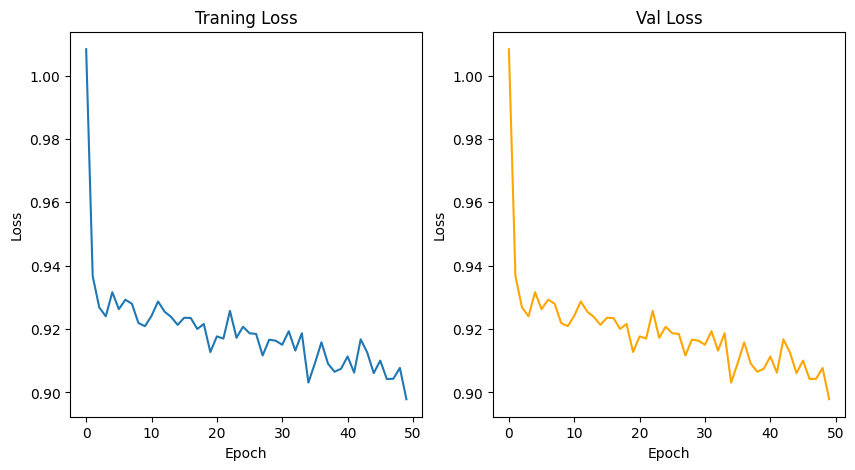

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(train_losses)
ax[0].set_title('Traning Loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')

ax[1].plot(train_losses, 'orange')
ax[1].set_title('Val Loss')
ax[1].set(xlabel='Epoch', ylabel='Loss')

plt.show()